In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# sportify specific
#from data.metrics import r_precision, cosine_sim_closest, cosine_sim_top, NDCG
from visualization.plot_utils import write_latex_table, summary_pooling_table,\
pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features import AudioFeatures, TrackInfo, Popularity, GenreFeatures, Word2vecFeature, ContextFeatures
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
# for bayesopt
import GPy
import GPyOpt
plot_settings()
pandas_settings()

def ranked_plots(pool,true,ranked,dist,f_name,r_type):
    sns.distplot([d for d,t in zip(dist,pool) if t in true],label='In playlist')
    sns.distplot([d for d,t in zip(dist,pool) if t not in true],label='Not in playlist')
    plt.ylabel('Normalized frequency')
    plt.xlabel('Distance')
    plt.title('{} with {}'.format(f_name,r_type))
    plt.legend()
    plt.show()
    true_rank = [i for i,t in enumerate(true)]
    estimated_rank = [i for i,t in enumerate(ranked) if t in true]
    
    plt.scatter(true_rank,estimated_rank)
    plt.plot([0, len(true)],[0, len(true)],'--',c='k',label='ideal')
    plt.xlabel('Real ranking')
    plt.ylabel('Estimated ranking')
    plt.title('{} with {}'.format(f_name,r_type))
    plt.show()

# Load track data and features

In [3]:
tracks = TrackInfo(subset='5k-')
feats = [Word2vecFeature(w2v_type='track', logging=True),
        Word2vecFeature(w2v_type='artist', logging=True),
        Word2vecFeature(w2v_type='album', logging=True),
        AudioFeatures(),
        Popularity(),
        GenreFeatures()]

../data/w2v/track_w2v_model_1min_100dim IS LOADING
LOADED W2V
../data/w2v/artist_w2v_model_1min_100dim IS LOADING
LOADED W2V
../data/w2v/album_w2v_model_1min_100dim IS LOADING
LOADED W2V
LOADING AUDIO FEATURE...
FINISHED LOADING AUDIO FEATURE...
../data/interim/track_uri2popularity.pkl.bz2 IS LOADING...
LOADED POPULARITY
LOADING GENRE..
LOADING FASTTEXT...
FINSIHED LOADING FASTTEXT..
FINISHED LOADING GENRE FEATURE


In [4]:
from data.metrics import r_precision, NDCG

def ranking_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a):
    rp_t = r_precision(true_t,pool_t)
    ndgc_t = NDCG(true_t,pool_t)
    rp_a = r_precision(true_a,pool_a)
    ndgc_a = NDCG(true_a,pool_a)
    return OrderedDict([('pid',pid),('k',k),('strat',strat),('n',n_pick),
                        ('rprecision_tracks',rp_t),('rprecision_artist',rp_a),
                        ('NDCG_tracks',ndgc_t),('NDCG_artist',ndgc_a)])


# Test one playlist vs 1 feature

In [ ]:
# select a feature
f = feats[0]
k=25
n_picks=5000
pid=194
strat='mean'
# rankign based on distances
turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
dist = f.distance_between_sets(turi_seed,turi_pool,strat)
sorted_indx=np.argsort(dist)
turi_ranked = [turi_pool[i] for i in sorted_indx]
auri_ranked = [auri_pool[i] for i in sorted_indx]
pd.DataFrame([ranking_stats(pid,k,strat,n_picks,turi_true,turi_pool,auri_true,auri_pool)])

In [ ]:
f_name= f.__class__.__name__
ranked_plots(turi_pool,turi_true,turi_ranked,dist,f_name,'Tracks')

# One playlist vs several features

In [ ]:
# select a feature
k=25
n_picks=5000
pid=194
strat='mean'
weights= [1 for f in feats]
# rankign based on distances
turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
# get scaled distance
dist = np.zeros(len(turi_pool))
for f,w in zip(feats,weights):
    dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
# rank based on 
sorted_indx=np.argsort(dist)
turi_ranked = [turi_pool[i] for i in sorted_indx]
auri_ranked = [auri_pool[i] for i in sorted_indx]
stats = ranking_stats(pid,k,strat,n_picks,turi_true,turi_pool,auri_true,auri_pool)
stats['rprecision_tracks']

# Bayesopt the weights and startegies

## Setup optimization parameter space


In [5]:
domains=[]
strats = ['mean','split']
strat_dom = tuple(list([i for i,x in enumerate(strats)]))
for f in feats:
    f_name = f.__class__.__name__
    domains.append({'name':'{}_weight'.format(f_name), 'type': 'continuous', 'domain': (0.,50.0)})
    #domains.append({'name':'{}_strat'.format(f_name), 'type': 'categorical', 'domain': strat_dom,'dimensionality': 1})
domains

[{'domain': (0.0, 50.0),
  'name': 'Word2vecFeature_weight',
  'type': 'continuous'},
 {'domain': (0.0, 50.0),
  'name': 'Word2vecFeature_weight',
  'type': 'continuous'},
 {'domain': (0.0, 50.0),
  'name': 'Word2vecFeature_weight',
  'type': 'continuous'},
 {'domain': (0.0, 50.0), 'name': 'AudioFeatures_weight', 'type': 'continuous'},
 {'domain': (0.0, 50.0), 'name': 'Popularity_weight', 'type': 'continuous'},
 {'domain': (0.0, 50.0), 'name': 'GenreFeatures_weight', 'type': 'continuous'}]

In [6]:
np.random.seed(42) 

verbose=True
iter_n=0
def rprecision_eval(x):
    global iter_n
    k=10
    n_picks=10000
    subset=500
    strat='mean'
    weights = [x[0][indx] for indx,i in enumerate(x[0])]
    stats=[]
    n_pids =100
    pids = [i for i in np.random.randint(0,5000,n_pids)]
    for pid in pids:
        turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
        if len(turi_true) > 0:
            # get scaled distance
            dist = np.zeros(len(turi_pool))
            for f,w in zip(feats,weights):
                dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
            # rank based on distance
            sorted_indx=np.argsort(dist)
            turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
            auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
            # get starts
            stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
    stats_df = pd.DataFrame(stats)
    # we wish to minize
    objective  = 1.0-np.mean(stats_df['rprecision_tracks'].values)
    #
    if verbose:
        print('{}: r-precision of {:.3f}'.format(iter_n,1-objective))
        print('\t {}'.format(str(['{:2.3f}'.format(w) for w in  weights])))
        iter_n+=1
    
    return objective


In [14]:
bopt = GPyOpt.methods.BayesianOptimization(f=rprecision_eval,                     # Objective function       
                                             domain=domains,          # Box-constraints of the problem
                                             initial_design_numdata = 3,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True,
                                             num_cores=3)           # True evaluations, no sample noise

20: r-precision of 0.177
	 ['33.859', '14.679', '13.979', '36.807', '9.431', '10.898']
21: r-precision of 0.175
	 ['24.705', '1.409', '41.181', '44.123', '46.776', '37.050']
22: r-precision of 0.218
	 ['8.160', '34.180', '32.796', '21.285', '49.791', '3.614']


In [15]:
max_iter=5
bopt.run_optimization(max_iter,eps=0)

23: r-precision of 0.231
	 ['5.480', '29.404', '19.532', '22.528', '42.405', '3.992']
24: r-precision of 0.217
	 ['3.055', '29.828', '28.980', '15.463', '48.890', '8.138']
25: r-precision of 0.217
	 ['4.643', '23.586', '26.024', '13.277', '48.526', '9.372']
26: r-precision of 0.212
	 ['0.000', '36.862', '3.442', '25.390', '45.728', '0.000']
27: r-precision of 0.236
	 ['0.000', '28.556', '23.444', '23.946', '32.513', '0.000']


In [74]:
# bopt.plot_convergence()
print ('----RESULT----')
print (bopt.x_opt)
print ("-----")
print (1-bopt.fx_opt)
print (bopt.fx_opt)

print (type(bopt.x_opt))
print (type(bopt.fx_opt))

k=10

----RESULT----
[ 0.         28.55568619 23.44387883 23.94591094 32.51272862  0.        ]
-----
[0.23559144]
[0.76440856]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [84]:
x = bopt.x_opt
k=10
n_picks=10000
subset=5000
strat='mean'
weights = [x[indx] for indx,i in enumerate(x)]
stats=[]
n_pids =100
pids = [i for i in np.random.randint(0,5000,n_pids)]
for pid in pids:
    turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
    if len(turi_true) > 0:
        # get scaled distance
        dist = np.zeros(len(turi_pool))
        for f,w in zip(feats,weights):
            dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
        # rank based on distance
        sorted_indx=np.argsort(dist)
        turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
        auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
        # get starts
        stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
stats_df_1 = pd.DataFrame(stats)
stats_df_1
stats_df_1 = stats_df_1.groupby('k').agg({'rprecision_tracks':'mean', 'rprecision_artist':'mean', 'NDCG_tracks':'mean', 'NDCG_artist':'mean'})
stats_df_1


,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
k,,,,
10,0.26,0.16,0.13,0.41


In [85]:
x = np.array([18.72700594, 29.93292421,  2.90418061, 35.40362889, 41.62213204,  9.17022549])
k=25
n_picks=10000
subset=5000
strat='mean'
weights = [x[indx] for indx,i in enumerate(x)]
stats=[]
n_pids =100
pids = [i for i in np.random.randint(0,5000,n_pids)]
for pid in pids:
    turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
    if len(turi_true) > 0:
        # get scaled distance
        dist = np.zeros(len(turi_pool))
        for f,w in zip(feats,weights):
            dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
        # rank based on distance
        sorted_indx=np.argsort(dist)
        turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
        auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
        # get starts
        stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
stats_df_2 = pd.DataFrame(stats)
stats_df_2
stats_df_2 = stats_df_2.groupby('k').agg({'rprecision_tracks':'mean', 'rprecision_artist':'mean', 'NDCG_tracks':'mean', 'NDCG_artist':'mean'})
stats_df_2

,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
k,,,,
25,0.19,0.16,0.13,0.36


In [86]:
x = np.array([39.90757788, 30.64030492,  0.73985602, 18.78637721, 46.2519237,  2.30703138])
k=50
n_picks=10000
subset=5000
strat='mean'
weights = [x[indx] for indx,i in enumerate(x)]
stats=[]
n_pids =100
pids = [i for i in np.random.randint(0,5000,n_pids)]
for pid in pids:
    turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
    if len(turi_true) > 0:
        # get scaled distance
        dist = np.zeros(len(turi_pool))
        for f,w in zip(feats,weights):
            dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
        # rank based on distance
        sorted_indx=np.argsort(dist)
        turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
        auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
        # get starts
        stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
stats_df_3 = pd.DataFrame(stats)
stats_df_3
stats_df_3 = stats_df_3.groupby('k').agg({'rprecision_tracks':'mean', 'rprecision_artist':'mean', 'NDCG_tracks':'mean', 'NDCG_artist':'mean'})
stats_df_3

,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
k,,,,
50,0.15,0.14,0.15,0.36


In [87]:
x = np.array([35.94795765, 25.70359594, 34.56771241,  1.9677634,  37.11594437, 43.87648044])
k=100
n_picks=10000
subset=5000
strat='mean'
weights = [x[indx] for indx,i in enumerate(x)]
stats=[]
n_pids =100
pids = [i for i in np.random.randint(0,5000,n_pids)]
for pid in pids:
    turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
    if len(turi_true) > 0:
        # get scaled distance
        dist = np.zeros(len(turi_pool))
        for f,w in zip(feats,weights):
            dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
        # rank based on distance
        sorted_indx=np.argsort(dist)
        turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
        auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
        # get starts
        stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
stats_df_4 = pd.DataFrame(stats)
stats_df_4
stats_df_4 = stats_df_4.groupby('k').agg({'rprecision_tracks':'mean', 'rprecision_artist':'mean', 'NDCG_tracks':'mean', 'NDCG_artist':'mean'})
stats_df_4


,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
k,,,,
100,0.11,0.12,0.17,0.43


In [88]:
final = pd.concat([stats_df_1, stats_df_2,stats_df_3, stats_df_4])
df = final


df


,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
k,,,,
10,0.26,0.16,0.13,0.41
25,0.19,0.16,0.13,0.36
50,0.15,0.14,0.15,0.36
100,0.11,0.12,0.17,0.43


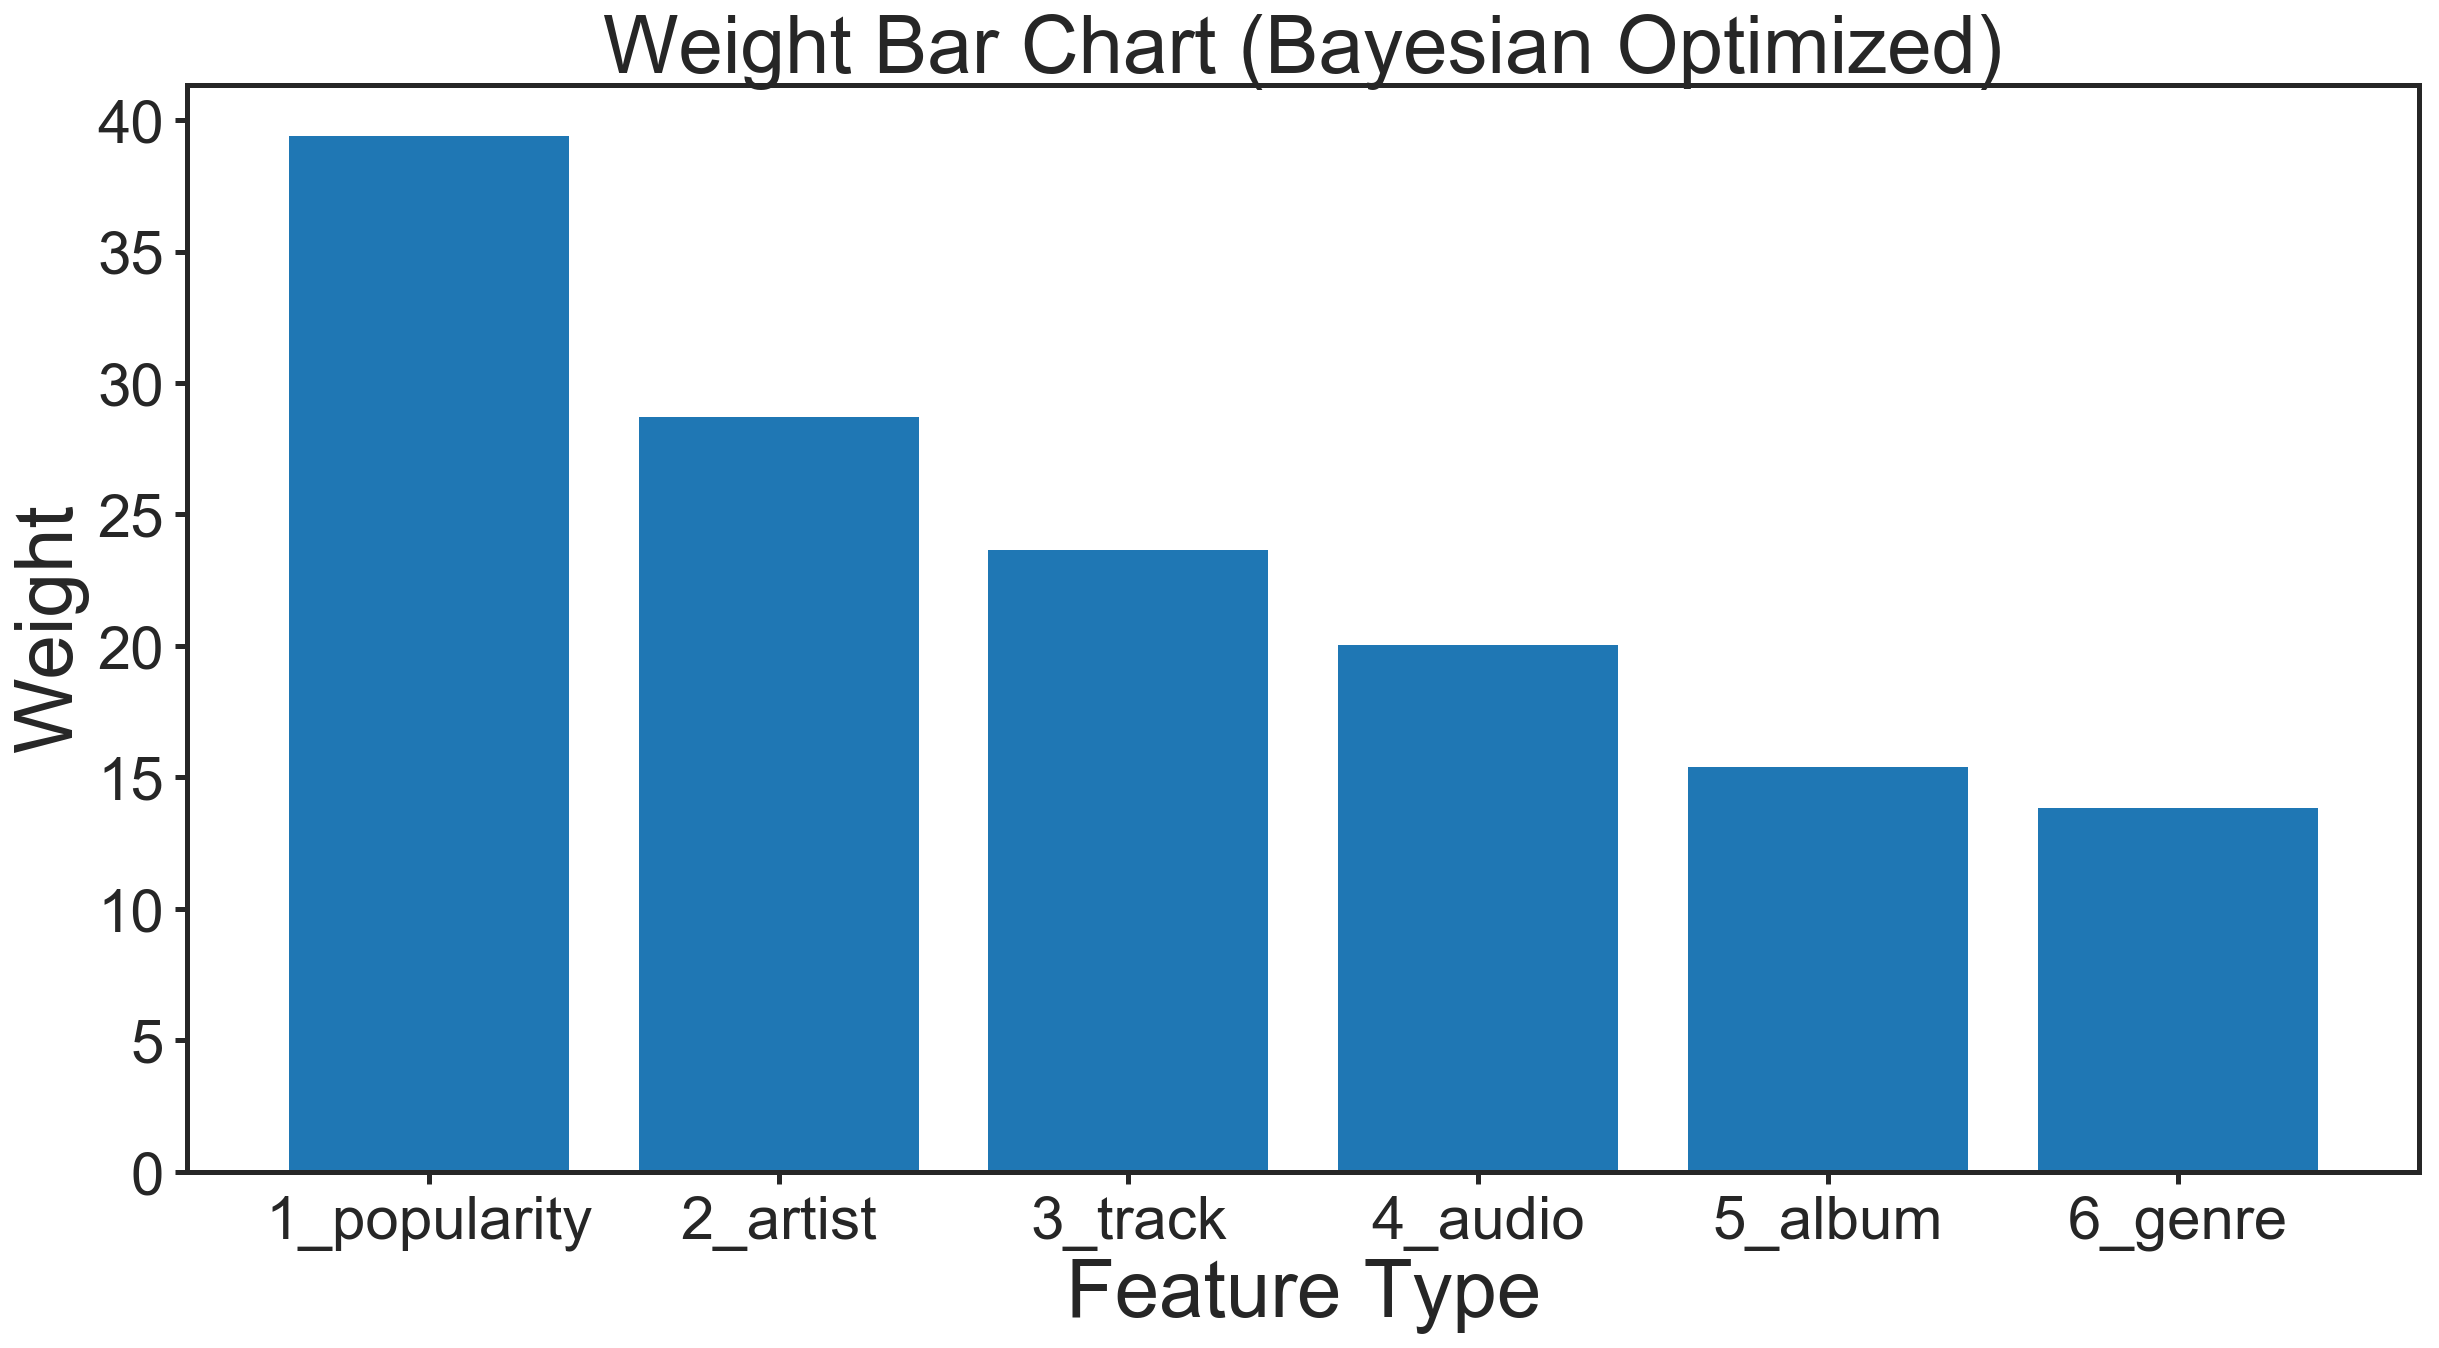

In [72]:
# average weight

a = np.array([ 0,         28.55568619, 23.44387883, 23.94591094, 32.51272862,  0        ])
b = np.array([18.72700594, 29.93292421,  2.90418061, 35.40362889, 41.62213204,  9.17022549])
c = np.array([39.90757788, 30.64030492,  0.73985602, 18.78637721, 46.2519237,  2.30703138])
d = np.array([35.94795765, 25.70359594, 34.56771241,  1.9677634,  37.11594437, 43.87648044])

x = ['3_track', '2_artist', '5_album', '4_audio', '1_popularity', '6_genre']
final = [a,b,c,d]
np.array(final).shape

out = np.mean(np.array(final), axis=0)


fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x, out)
plt.title('Weight Bar Chart (Bayesian Optimized)', fontsize=40)
plt.ylabel('Weight', fontsize=40)
plt.xlabel('Feature Type', fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
fig.savefig('test2png.png', dpi=300)
